In [1]:
from datetime import date
import time

import warnings
warnings.filterwarnings(action='once')


from fidelity import *
from povm import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline


today = date.today()
datestr = today.strftime("%y%m%d")


# Hyperparameters
Nq = 6
split = 0.8
# Nf = int(sys.argv[3])

povm = POVM('pauli6')
Na = povm.Na

In [3]:
# GHZ state density matrix
Ne = 4
rhoKB = np.zeros((Ne, 2*Nq), dtype=int)
rhoAmp = np.zeros((Ne), dtype=complex)

rhoKB[1, :] = 1
rhoKB[2, :Nq] = 1
rhoKB[3, Nq:] = 1

rhoAmp[0] = 0.5
rhoAmp[1] = 0.5
rhoAmp[2] = 0.5
rhoAmp[3] = np.conj(rhoAmp[2])


density = {}
density['KB'] = rhoKB
density['Amp'] = rhoAmp


ghz = SampleDM(Nq, povm, density)

# GHZ state density matrix
Ne = 4
rhoKB = np.zeros((Ne, 2*Nq), dtype=int)
rhoAmp = np.zeros((Ne), dtype=complex)

rhoKB[1, :] = 1
rhoKB[2, :Nq] = 1
rhoKB[3, Nq:] = 1

rhoAmp[0] = 0.5
rhoAmp[1] = 0.5
rhoAmp[2] = 0.
rhoAmp[3] = np.conj(rhoAmp[2])


density = {}
density['KB'] = rhoKB
density['Amp'] = rhoAmp


ghz_cl = SampleDM(Nq, povm, density)


# Generate Probability table

In [43]:
from ann import *

Ns = 40000

tag = 'errorscaling/ghz-errorscaling'

Nep = 200
for Ns in [40000, 80000, 130000, 200000, 400000]:
    model = torch.load(f='%s-%i_2-64-4_6-%i.mod'%(tag, Nep, Ns))

    t = time.time()
    pt_model = POVMProbTable(model)

    np.save('%s-%i_2-64-4_6-%i_pt.npy'%(tag, Nep, Ns), pt_model)
    print('%f seconds'%(time.time()-t))

111.020447 seconds
113.158533 seconds
112.497137 seconds
114.401576 seconds
115.499567 seconds


# Error scaling

In [4]:
pt_ghz = POVMProbTable(ghz)

In [5]:
Ns_list = np.array([40000, 80000, 130000, 200000, 400000])
Nep_list = np.array([200, 400, 600])


pt_model = np.zeros((len(Ns_list), len(Nep_list), len(pt_ghz)))
pt_data = np.zeros((len(Ns_list), len(pt_ghz)))

tag = 'errorscaling/ghz-errorscaling'


for i in range(len(Ns_list)):
    for j in range(len(Nep_list)):
        Ns = Ns_list[i]
        Nep = Nep_list[j]

        pt_model[i, j] = np.load('%s-%i_2-64-4_6-%i_pt.npy'%(tag, Nep, Ns))

    data = np.load('data/ghz-sim-Pauli6-Nq6-Ns%i.npy'%Ns)

    for d in data:
        pt_data[i, basestr2int(d, Na)] += 1/len(data)


In [6]:
print(sum(pt_ghz))
print([np.sum(a, 1) for a in pt_model])
print([sum(a) for a in pt_data])

0.9999999999997934
[array([0.99999092, 0.99999214, 0.99999228]), array([0.99999901, 0.9999987 , 0.99999558]), array([0.99999548, 0.99999652, 0.99999852]), array([0.99999917, 0.99999741, 0.99999993]), array([0.99999979, 0.99999992, 0.99999997])]
[1.0000000000002296, 1.0000000000001676, 1.0000000000000282, 1.0000000000000286, 1.000000000000022]


In [7]:
sd_model = np.zeros((len(Ns_list), len(Nep_list)))
sd_data = np.zeros((Ns_list.shape))

for i in range(len(Ns_list)):
    for j in range(len(Nep_list)):
        sd_model[i, j] = np.sqrt(np.mean((pt_ghz-pt_model[i, j])**2))
        sd_data[i] = np.sqrt(np.mean((pt_ghz-pt_data[i])**2))

In [8]:
print(sd_data)
print(sd_model)

[2.31271058e-05 1.62340819e-05 1.29398586e-05 1.03590042e-05
 7.37763182e-06]
[[6.49325631e-06 8.56895141e-06 1.10010821e-05]
 [5.50261509e-06 7.32833451e-06 8.12960595e-06]
 [5.29506069e-06 5.05774709e-06 6.54834306e-06]
 [3.44628533e-06 3.98212593e-06 5.50637080e-06]
 [2.01583940e-06 3.36154706e-06 4.05666493e-06]]


In [9]:
print(np.std(sd_model, 1))

[1.84222884e-06 1.09931131e-06 6.53954703e-07 8.72696948e-07
 8.47157785e-07]


[-0.49534174 -5.42861318]
[-0.45256985 -6.80792894]


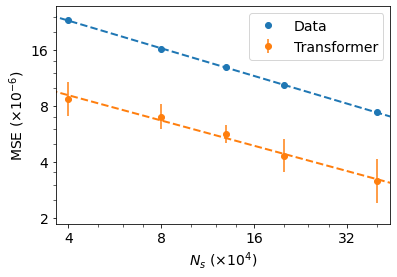

In [10]:
fig, ax = plt.subplots()

p_data = np.polyfit(np.log(Ns_list), np.log(sd_data), deg=1)

sd_model_0 = np.mean(sd_model, 1)
sd_model_1 = np.std(sd_model, 1)
p_model = np.polyfit(np.log(Ns_list), np.log(sd_model_0), deg=1)

fx = np.array([10, 15])
ax.plot(fx, np.polyval(p_data, fx), linestyle='--', color='tab:blue', linewidth=2)
ax.plot(fx, np.polyval(p_model, fx), linestyle='--', color='tab:orange', linewidth=2)

ax.plot(np.log(Ns_list), np.log(sd_data), marker='.', markersize=12, linestyle='', color='tab:blue', label='Data')
# ax.plot(np.log(Ns_list), np.log(sd_model), marker='.', markersize=12, linestyle='', color='tab:orange', label='Transformer')
ax.errorbar(np.log(Ns_list), np.log(sd_model_0), yerr=sd_model_1/sd_model_0, marker='.', markersize=12, linestyle='', color='tab:orange', label='Transformer')


xticks_major = np.array([4, 8, 16, 32])*10**4
xticklabels_major = np.array(['%i'%x for x in [4, 8, 16, 32]])

xticks_minor = np.array([5, 6, 7, 10, 12, 14, 20, 24, 28, 40])*10**4
ax.set_xticks(np.log(xticks_major))
ax.set_xticklabels(xticklabels_major, size=14)
ax.set_xticks(np.log(xticks_minor), minor=True)
ax.xaxis.set_tick_params(which='minor', length=3)

ax.set_xlabel('$N_s\\ (\\times10^4)$', size=14)

yticks_major = np.array([2, 4, 8, 16])*10**(-6)
yticks_minor = np.array([2.5, 3, 3.5, 5, 6, 7, 10, 12, 14, 20, 24])*10**(-6)
yticklabels_major = np.array(['%i'%y for y in [2, 4, 8, 16]])

ax.set_yticks(np.log(yticks_major))
ax.set_yticks(np.log(yticks_minor), minor=True)
ax.set_yticklabels(yticklabels_major, size=14)
ax.yaxis.set_tick_params(which='minor', length=3)
ax.set_ylabel('MSE $(\\times10^{-6})$', size=14)

ax.set_xbound(10.5, 13)
ax.set_ybound(-13.2, -10.5)
ax.legend(fontsize=14)


print(p_data)
print(p_model)

# fig.savefig('figures/povm_error_scaling.pdf', dpi=300, frameon=True,bbox_inches="tight")

# Histogram

In [55]:
pt_ghz = POVMProbTable(ghz)
pt_ghzcl = POVMProbTable(ghz_cl)

In [56]:
Ns = 200000
Nep = 400

tag = 'errorscaling/ghz-errorscaling'
# tag = 'data/aqt-ghz-large'

pt_model = np.load('%s-%i_2-64-4_6-%i_pt.npy'%(tag, Nep, Ns))

data = np.load('data/ghz-sim-Pauli6-Nq6-Ns%i.npy'%Ns)
pt_data = np.zeros(pt_model.shape)

for d in data:
    pt_data[basestr2int(d, Na)] += 1./len(data)
print(np.sqrt(np.mean((pt_ghz-pt_model)**2)))
print(np.sqrt(np.mean((pt_ghz-pt_data)**2)))

3.982125934364559e-06
1.0359004206496893e-05


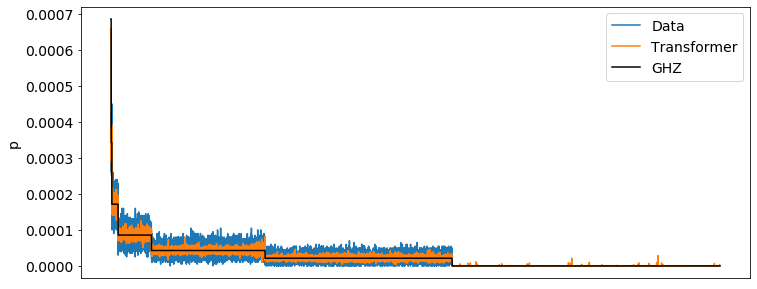

In [57]:
ghz_as = np.flip(np.argsort(pt_ghz))

fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(start=1, stop=len(pt_ghz)+1)

ax.plot(x, pt_data[ghz_as], label='Data')
ax.plot(x, pt_model[ghz_as], label='Transformer')
ax.plot(x, pt_ghz[ghz_as], label='GHZ', color='black')

# axins = inset_axes(ax,6,2,bbox_to_anchor=(-0.06,-0.02, 1,1),bbox_transform=ax.transAxes)
# ghz_as_pos = (pt_ghz[ghz_as] > 0)

# axins.plot(pt_data[ghz_as][ghz_as_pos])
# axins.plot(pt_model[ghz_as][ghz_as_pos])
# axins.plot(pt_ghz[ghz_as][ghz_as_pos], color='black')
# axins.set_xticks([])

ax.set_xticks([])
ax.set_ylabel('p', size=14)
ax.tick_params(axis='y', labelsize=14)

ax.legend(fontsize=14)
# fig.savefig('figures/povm_sorted.pdf', dpi=300, frameon=True,bbox_inches="tight")

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


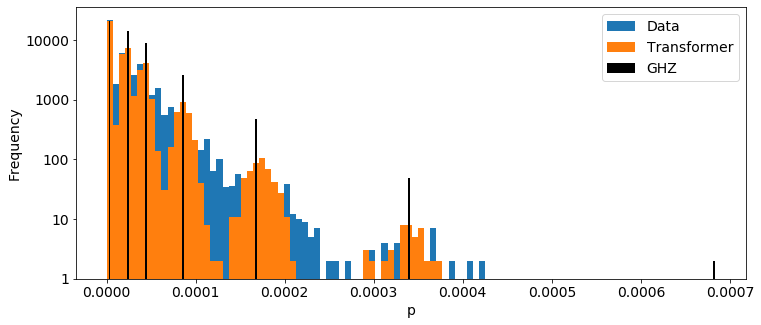

In [58]:

Nbin = 100

xbin, dx = np.linspace(start=min(pt_ghz), stop=max(pt_ghz), num=Nbin+1, retstep=True)

x = (xbin[:-1]+xbin[1:])/2

h_ghz, _ = np.histogram(pt_ghz, bins=xbin)
h_data, _ = np.histogram(pt_data, bins=xbin)
h_model, _ = np.histogram(pt_model, bins=xbin)

fig, ax = plt.subplots(figsize=(12,5))




ax.bar(x, np.log(h_data), width=dx, label='Data')
ax.bar(x, np.log(h_model), width=dx, label='Transformer')
ax.bar(x, np.log(h_ghz), width=0.3*dx, label='GHZ', color='black')

yticks = [1, 10, 100, 1000, 10000]
ax.set_yticks(np.log(yticks))
ax.set_yticklabels(['%i'%i for i in yticks])
ax.set_ylabel('Frequency', size=14)
ax.set_xlabel('p', size=14)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=14)

# fig.savefig('figures/povm_histogram.pdf', dpi=300, frameon=True,bbox_inches="tight")

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


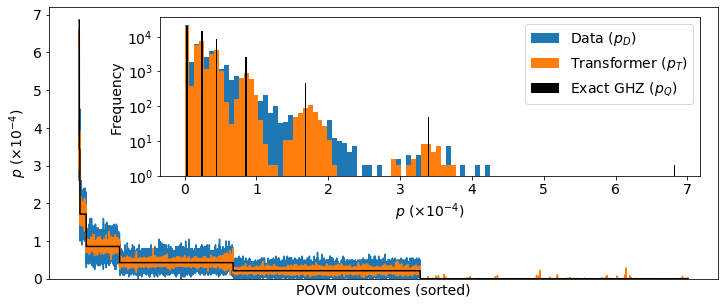

In [69]:
ghz_as = np.flip(np.argsort(pt_ghz))

fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(start=1, stop=len(pt_ghz)+1)

ax.plot(x, pt_data[ghz_as], label='Data')
ax.plot(x, pt_model[ghz_as], label='Transformer')
ax.plot(x, pt_ghz[ghz_as], label='GHZ', color='black')

axins = inset_axes(ax,7.5,2.2,bbox_to_anchor=(-0.02,-0.02, 1,1),bbox_transform=ax.transAxes)

Nbin = 100

xbin, dx = np.linspace(start=min(pt_ghz), stop=max(pt_ghz), num=Nbin+1, retstep=True)

x = (xbin[:-1]+xbin[1:])/2

h_ghz, _ = np.histogram(pt_ghz, bins=xbin)
h_data, _ = np.histogram(pt_data, bins=xbin)
h_model, _ = np.histogram(pt_model, bins=xbin)

axins.bar(x, np.log(h_data), width=dx, label='Data ($p_D$)')
axins.bar(x, np.log(h_model), width=dx, label='Transformer ($p_T$)')
axins.bar(x, np.log(h_ghz), width=0.3*dx, label='Exact GHZ ($p_Q$)', color='black')

yticks = [1, 10, 100, 1000, 10000]
axins.set_yticks(np.log(yticks))
axins.set_yticklabels(['$10^%i$'%i for i in range(len(yticks))])
axins.set_xticks(np.array([0, 1, 2, 3, 4, 5, 6, 7])*10**(-4))
axins.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])
axins.set_ylabel('Frequency', size=14)
axins.set_xlabel('$p$ $(\\times 10^{-4})$', size=14)
axins.tick_params(axis='both', labelsize=14)
axins.legend(fontsize=14)
# axins.plot(pt_data[ghz_as][ghz_as_pos])
# axins.plot(pt_model[ghz_as][ghz_as_pos])
# axins.plot(pt_ghz[ghz_as][ghz_as_pos], color='black')
# axins.set_xticks([])

ax.set_ylim(bottom=0)
ax.set_xticks([])
ax.set_yticks(np.array([0, 1, 2, 3, 4, 5, 6, 7])*10**(-4))
ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_ylabel('$p$ $(\\times 10^{-4})$', size=14)
ax.set_xlabel('POVM outcomes (sorted)', size=14)
ax.tick_params(axis='y', labelsize=14)

# ax.legend(fontsize=14)
fig.savefig('figures/povm_probabilities.pdf', dpi=300, frameon=True,bbox_inches="tight")